In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import date, timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

def get_day_cases(end_date=date.today()):
    """
    Gets day-by-day case numbers.

    Input: end date (optional)
    Output: array of dataframes, indexed from 0 = 4/12/20
    """
    START_DATE = date(2020, 4, 12)
    GIT_REPO_PATH = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/'
    num_days = (end_date - START_DATE).days
    dfs = []
    for i in range(num_days):
        year, mo, day = (START_DATE + timedelta(days=i)).isoformat().split('-')
        file_name = '{0}-{1}-{2}.csv'.format(mo, day, year)
        dfs.append(pd.read_csv(GIT_REPO_PATH + file_name, error_bad_lines=False))
    return dfs

pd.options.display.max_seq_items = None

Let's start by looking at California's counties.

In [10]:
counties = pd.read_csv('covid19/small_abridged.csv')

cases = pd.read_csv('county_info_cases_deaths.csv')
county_unique_columns = []
for i in counties.columns:
    if i not in cases.columns:
        county_unique_columns += [i]
county_unique_columns += ['CountyName']
cases_info = cases.merge(counties[county_unique_columns], how='left', on='CountyName')
ca = cases_info.loc[cases_info['StateName'] == 'CA']
ca

,Unnamed: 0,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,...,Chlamydia Rate,Teen Birth Rate,Preventable Hospitalization Rate,% Vaccinated,Violent Crime Rate,Injury Death Rate,Average Daily PM2.5,Presence of Water Violation,% Drive Alone to Work,% Long Commute - Drives Alone
1034,180,6001,6.0,1.0,Alameda,CA,California,37.646537,-121.849494,37.705201,...,553.2,11.408149,3298.0,44.0,628.781962,42.021286,10.4,0.0,61.489237,46.4
1035,181,6003,6.0,3.0,Alpine,CA,California,38.595405,-119.817665,38.728298,...,803.6,NaN,2480.0,21.0,442.477876,217.470098,5.6,0.0,66.011236,35.3
1036,182,6005,6.0,5.0,Amador,CA,California,38.452565,-120.640865,38.394208,...,170.9,18.101093,3115.0,46.0,237.070738,97.813731,8.9,0.0,80.634378,41.4
1037,183,6007,6.0,7.0,Butte,CA,California,39.667234,-121.600771,39.669037,...,527.3,17.643410,4656.0,39.0,327.057309,98.235283,8.9,1.0,75.287737,24.1
1038,183,6007,6.0,7.0,Butte,CA,California,39.667234,-121.600771,39.669037,...,153.7,NaN,2548.0,27.0,138.861337,93.479785,5.8,0.0,76.373057,23.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,233,6107,6.0,107.0,Tulare,CA,California,36.218127,-118.791993,36.251227,...,554.2,37.738078,4469.0,41.0,381.807643,58.254059,17.8,1.0,78.130283,26.2
1115,234,6109,6.0,109.0,Tuolumne,CA,California,38.028841,-119.955589,37.971531,...,267.3,16.505726,2464.0,45.0,316.156731,101.062077,8.9,1.0,81.362365,25.8
1116,235,6111,6.0,111.0,Ventura,CA,California,34.490146,-119.071524,34.241989,...,333.3,17.919179,3359.0,45.0,240.489673,50.286454,11.2,1.0,78.485469,34.9
1117,236,6113,6.0,113.0,Yolo,CA,California,38.691680,-121.904841,38.598913,...,491.1,9.352084,2878.0,50.0,331.889440,48.423135,9.8,0.0,68.164460,31.8


For our project, we are examining the relationship between a county's SVI score and COVID-19's impact on that county, in terms of case rate and death rate. First we'll examine cases.

In [46]:
cases_columns, death_columns = [], []
for i in ca.columns:
    if 'cases' in i:
        cases_columns += [i]
    elif 'death' in i:
        death_columns += [i]
cases_only = ca[cases_columns].copy()
cases_only['pop'] = ca['PopulationEstimate2018'].copy()
cases_only['mean_svi'] = ca['SVIPercentile'].copy()
cases_only
deaths_only = ca[death_columns].copy()
deaths_only['pop'] = ca['PopulationEstimate2018'].copy()
deaths_only['mean_svi'] = ca['SVIPercentile'].copy()

def plot_svi_bins(df=cases_only, num_bins=4, cases=True):
    bins = list(np.arange(0,  1+(1/num_bins), 1/num_bins))
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)
    for i in range(num_bins):
        binned = df.loc[df['mean_svi'] > bins[i]]
        binned = df.loc[df['mean_svi'] < bins[i+1]]
        binned = binned.sum(axis=0)[:-1]
        binned = binned / binned[-1]
        binned = binned[:-1]
        if cases:
            binned.index = pd.to_datetime(binned.index.str.replace('_cases', ''))
        else:
            binned.index = pd.to_datetime(binned.index.str.replace('_deaths', ''))
        sns.lineplot(x = binned.index, y = binned.values, ax=ax, label = str(bins[i]) + '-' + str(bins[i+1]))
    plt.xlabel('Time')
    if cases:
        plt.ylabel('Case Rate (per person)')
        plt.title('Case Rate Over Time')
    else:
        plt.ylabel('Death Rate (per person)')
        plt.title('Death Rate Over Time')
    plt.setp(ax.get_xticklabels(), rotation=60)
    ax.legend()
    plt.legend(title = "SVI Percentile")
    plt.show()

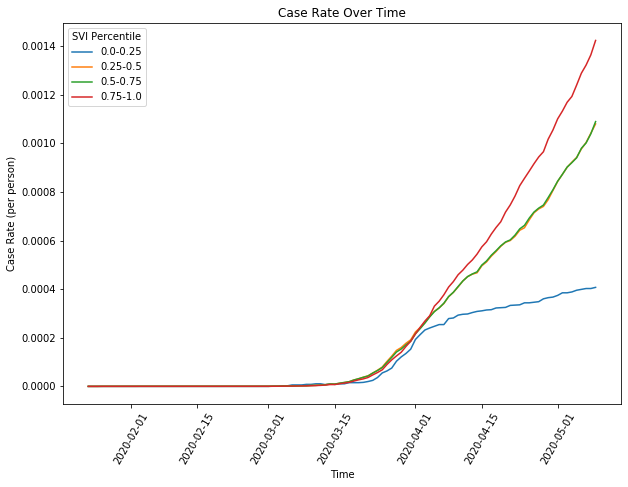

In [47]:
plot_svi_bins()

Unsurprisingly, we see that counties with the highest social vulnerability have the steepest cases curve. There is a surprising flat plateau to the counties with the lowest social vulnerability. The following cell shows the death rates.

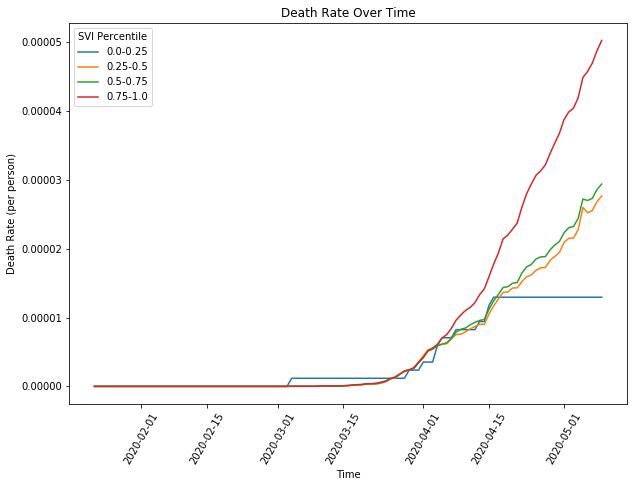

In [48]:
plot_svi_bins(df=deaths_only, cases=False)

Once again we see that the least vulnerable counties, understandably, have had the smallest impact from covid.
Now we'll examine which factors of SVI have the largest impact on COVID's case and death rate among counties.

In [49]:
svi_columns = ['SVIPercentileSEtheme', 'SVIPercentileHDtheme', 
                  'SVIPercentileMLtheme', 'SVIPercentileHTtheme']
svi_df = ca[svi_columns]
svi_columns

corr = []
log_log_corr = []

#cases_only = cases_only.drop('mean_svi', axis=1)
max_cases = cases_only[np.argmax(cases_only.sum(axis=0)[:-1])]
max_cases = max_cases / ca['PopulationEstimate2018']
max_cases_logged = np.log(max_cases)
for col in svi_columns:
    column = svi_df[col]
    corr.append((col, column.corr(max_cases)))
    log_log_corr.append((col, np.log(column).corr(max_cases_logged)))
    


In [50]:
print('Correlation with cases from', np.argmax(cases_only.sum(axis=0)[:-1])) 
print(sorted([x for x in corr if x[1] <= 1 and x[1] >= -1], key=lambda x:abs(x[1]), reverse=True)[:10])
print('\nLog Correlation with cases from', np.argmax(cases_only.sum(axis=0)[:-1]))
print(sorted([x for x in log_normal_corr if x[1] <= 1 and x[1] >= -1], key=lambda x:abs(x[1]), reverse=True)[:10])

Correlation with cases from pop
[]

Log Correlation with cases from pop
[('SVIPercentileHDtheme', -0.14150729882679342), ('SVIPercentileHTtheme', 0.13583653281553779), ('SVIPercentileMLtheme', 0.06593084418448739), ('SVIPercentileSEtheme', 0.020086316341983764)]


In [42]:
deaths_only = deaths_only.drop('mean_svi', axis=1)

In [52]:
corr = []
log_log_corr = []


max_deaths = deaths_only[np.argmax(deaths_only.sum(axis=0)[:-1])]
max_deaths = ca['PopulationEstimate2018']
max_deaths_logged = np.log(max_deaths)
for col in svi_columns:
    column = svi_df[col]
    corr.append((col, column.corr(max_deaths)))
    log_log_corr.append((col, np.log(column).corr(max_deaths_logged)))
    

print('Correlation with deaths from', np.argmax(deaths_only.sum(axis=0)[:-1])) 
print(sorted([x for x in corr if x[1] <= 1 and x[1] >= -1], key=lambda x:abs(x[1]), reverse=True)[:10])
print('\nLog Correlation with deaths from', np.argmax(deaths_only.sum(axis=0)[:-1]))
print(sorted([x for x in log_normal_corr if x[1] <= 1 and x[1] >= -1], key=lambda x:abs(x[1]), reverse=True)[:10])

Correlation with deaths from pop
[('SVIPercentileHDtheme', -0.19286789463424173), ('SVIPercentileHTtheme', 0.15511723672169334), ('SVIPercentileSEtheme', -0.11144153316641105), ('SVIPercentileMLtheme', 0.10828420515898192)]

Log Correlation with deaths from pop
[('SVIPercentileHDtheme', -0.14150729882679342), ('SVIPercentileHTtheme', 0.13583653281553779), ('SVIPercentileMLtheme', 0.06593084418448739), ('SVIPercentileSEtheme', 0.020086316341983764)]


Recall:
<li><b>Socioeconomic Theme</b>: the county's percentile ranking from the SVI socioeconomic theme, which accounts for poverty level, unemployment, income, high school diploma.</li>
<li><b>Housing Composition & Disability</b>: the county's percentile ranking from the SVI housing composition and disability theme, which accounts for composition of those $\geq$ 65, $\leq$ 17, >5 with a disability, and single-parent households.</li>
<li><b>Minority status and language</b>: the county's percentile ranking from the SVI minority status and language theme, which accounts for minority status and if one speaks English "less than well"</li>
<li><b>Housing & Transportation</b>: the county's percentile ranking from the SVI housing and transportation theme, which accounts for multi-unit structures, mobile homes, crowding, no vehicles, and group quarters</li>


All these correlations seem to be fairly low, with the SE theme seemingly uncorrelated with the virus impact. The numbers are still somewhat informative, and seem to imply the HD theme as being the most correlated with covid impact (both in cases and deaths). The correlation is negative, however, which is surprising. One possible explanation for this negative correlation is that fewer people in disabled households get tested, resulting in fewer relative cases and deaths compared to people in able households. The housing and trasportation theme, which we originally predicted to have the greatest correlation on COVID19 cases and deaths, does in fact have the largest positive correlation. People living in multi-unit structures and mobile homes are more suceptible to COVID19, and people forced to use public transit are also more suceptible to COVID19 than those who have their own vehicles

Does the SVI theme that affects COVID the most change over time? For example, could social distancing measures make one theme more (or less) important?

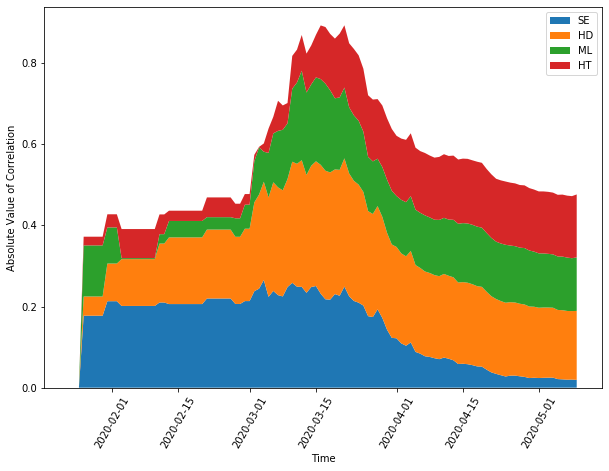

In [101]:
case_matrix = cases_only.iloc[:,:-2]
x = pd.to_datetime(case_matrix.columns.str.replace('_cases', ''))

y = np.ndarray(shape=(4, x.size))


def get_svi_corr(columm):
    return column.corr(svi_df['SVIPercentileSEtheme'])
for i in range(4):
    y[i] = case_matrix.apply(lambda x: x.corr(svi_df[svi_columns[i]]))
fig = plt.figure(figsize=(10, 7))
y = np.nan_to_num(y)
y = np.abs(y)
p = plt.stackplot(x, y, labels = ['SE', 'HD', 'ML', 'HT'])
plt.xlabel('Time')
plt.ylabel('Absolute Value of Correlation')
plt.legend()
plt.xticks(rotation=60)
plt.show()